## add to path 

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# open loop

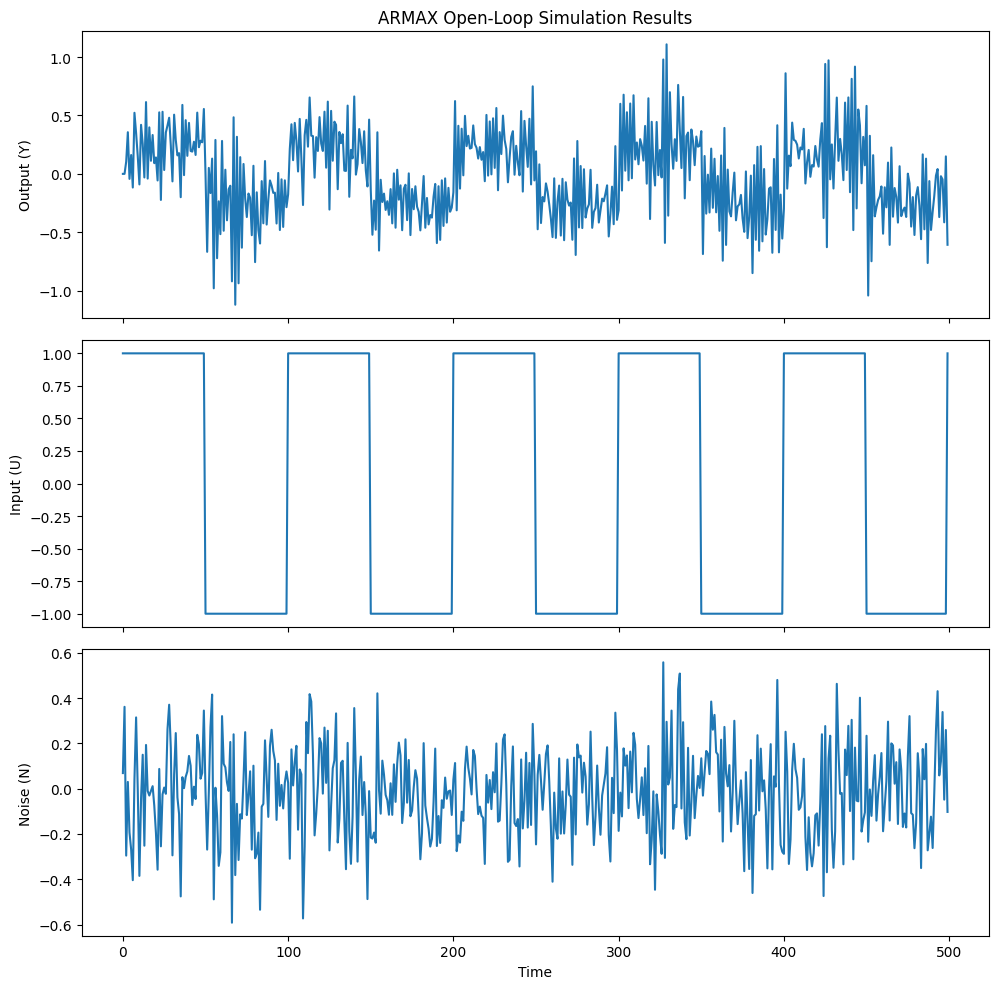

(2, 500) (1, 500)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# Plotting
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True  # Use full LaTeX engine

class ARMAX:
    def __init__(self, A, B, C):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
    
    def simulate_open_loop(self, n_samples, U=None, noise_std=0.1):
        Y = np.zeros((2, n_samples))
        N = np.random.normal(0, noise_std, n_samples)
        
        if U is None:
            U = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C))
        
        for t in range(max_order, n_samples):
            Y[0,t] = (- np.dot(self.A[1:], Y[0,t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            if t>max_order:
                Y[1,t] = Y[0,t] - Y[0,t-1]

        
        return Y, U, N

    def plot_results(self, Y, U, N, R=None):
        fig, axs = plt.subplots(4 if R is not None else 3, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y[0])
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        if R is not None:
            axs[3].plot(R)
            axs[3].set_ylabel('Reference (R)')
            axs[3].set_xlabel('Time')
        else:
            axs[2].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, 0.7]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
B = [0.4]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1]               # 

armax_model = ARMAX(A, B, C)

n_samples = 500
U = 1* signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, noise = armax_model.simulate_open_loop(n_samples, U, noise_std=0.2)
armax_model.plot_results(Y, U, noise)  # No R needed for open-loop
U = U.reshape(1, -1)
print(Y.shape, U.shape)


True


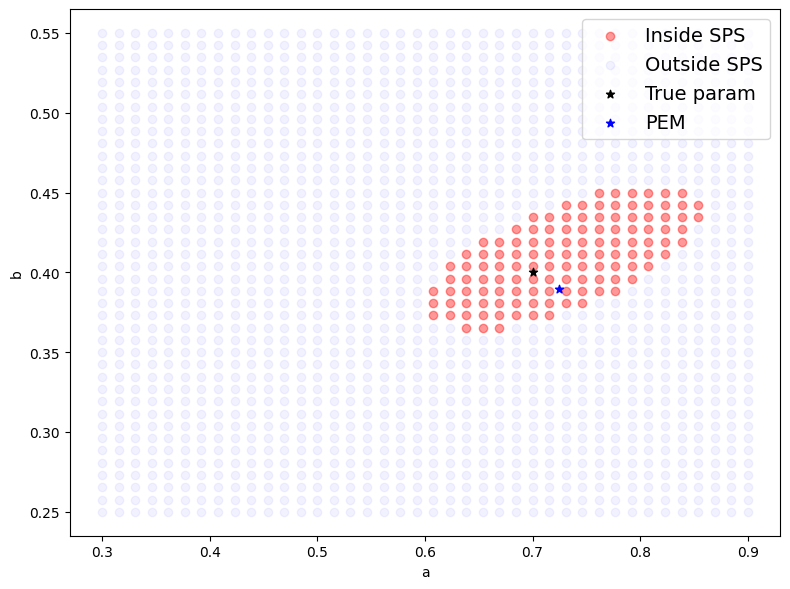

In [ ]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=1
center = [0.7, 0.4]
C_obs = np.array([[1]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 200

n_output=1
n_states=1
n_inputs=1

def get_error_norm(point, Y, U):
    A = np.array(point[:1])
    A = np.hstack([1, A])
    B = np.array(point[1:])
    B = np.hstack([0, B])
    G = d_tfs((B, A))
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    try:
        d_tfs.sps_assumption_check(G,0, epsilon)
    except:
        return 1e10

    C = np.array([1])
    Hinv = d_tfs((A, C))

    YGU = Y - G*U
    N = Hinv*YGU
    Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
    error_norm = np.linalg.norm(Lambda@N@N.T)
    return error_norm
def get_lse(Y,U):
    x0 = np.zeros(4)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y,U)

model2  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=1, 
                            n_noise=-1)
Y0 = Y[0,:].reshape(1, -1)
def is_inside_region2(point):
    try :
        A = np.array(point[:1])
        A = np.hstack([1, A])
        B = np.array(point[1:])
        B = np.hstack([0, B])
        G = d_tfs((B, A))
        if not _is_stable(A, epsilon=epsilon):
            return False
        
        d_tfs.sps_assumption_check(G,0, epsilon)

        C = np.array([1.0])
        H = d_tfs((C, A))

        d_tfs.sps_assumption_check(H,1.0, epsilon)

        in_sps = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y0, U_t=U.reshape(1,-1), sps_type=SPSType.OPEN_LOOP)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps

print(is_inside_region2(np.array(center)))


# Grid resolution
a_vals = np.linspace(0.3, 0.9, 40)
b_vals = np.linspace(0.25, 0.55, 40)

blue_pts = []
red_pts = []

As = []
Bs = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b])
        if is_inside_region2(point):
            blue_pts.append([a, b])
            As.append(a)
            Bs.append(b)
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# plt.rcParams.update({
#     'font.size': 38,         # Base font size (a little bigger)
#     'axes.titlesize': 42,    # Title font (a little bigger)
#     'axes.labelsize': 38,    # X/Y label font (a little bigger)
#     'xtick.labelsize': 34,   # X tick labels (a little bigger)
#     'ytick.labelsize': 34,   # Y tick labels (a little bigger)
#     'legend.fontsize': 34,   # Legend font (a little bigger)
#     'figure.titlesize': 42,  # Suptitle font (a little bigger)
# })
plt.figure(figsize=(8, 6))  # Larger figure size for better scaling in LaTeX
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='red', label='Inside SPS', alpha=0.4)
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='blue', label='Outside SPS', alpha=0.05)
plt.scatter(center[0], center[1], color='black', marker='*', label='True param')
plt.scatter(lse[0], lse[1], color='blue', marker='*', label='PEM')
plt.xlabel("a")
plt.ylabel("b")
# plt.title(r"SPS SISO without Weight $\left(\Psi_n^{\frac{-1}{2}}\right)$")
plt.legend(fontsize=14)
# plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
# plt.grid(True)
plt.tight_layout()
plt.savefig("sps_siso.svg", bbox_inches='tight')
plt.show()



# closed loop

[[0.28204492]]
[4.512718708375432]
(1, 500) (1, 500) (1, 500)


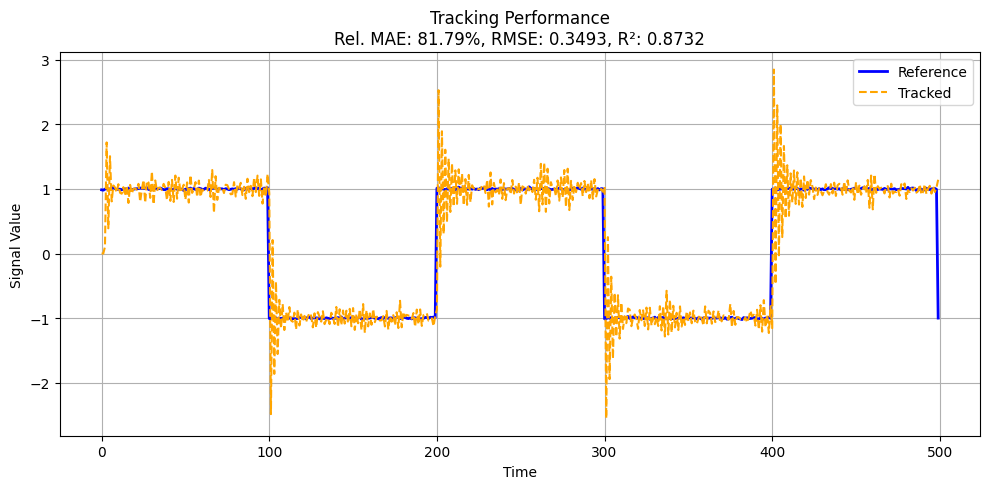

{'relative mae': 0.8179419923923743,
 'rmse': 0.34930273762294867,
 'r2': 0.8731824872913836}

In [ ]:
Q = 0.4 * np.eye(1)
R = 1.2*np.eye(1)
K = get_optimal_controller(np.array(As), np.array(Bs), Q, R)
# U = FR - LU
print(K)

from indirect_identification.armax import ARMAX
from scipy.signal import lfilter, square
import numpy as np
# Example usage
A = [1.0, 0.7]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
B = [0.4]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1.0]               # C(z^-1) = 1
F = K[0]
L = [F[0]*16]     # L(z^-1) = 1
print(L)
armax_model = ARMAX(A, B, C, F, L)

n_samples = 500
# square wave reference signal
R = square(np.linspace(0, 5*np.pi, n_samples)) + np.random.normal(0, 0.01, size=n_samples)

Y, U, N, R = armax_model.simulate(n_samples, R=R, noise_std=0.08)
# armax_model.plot_results(Y, U, N, R)
# get Y delayed by 1 sample
Y_tm1 = lfilter([1, -1], [1], Y)
Y = Y.reshape(1,-1)
U = U.reshape(1,-1)
R = R.reshape(1,-1)
print(Y.shape, U.shape, R.shape)


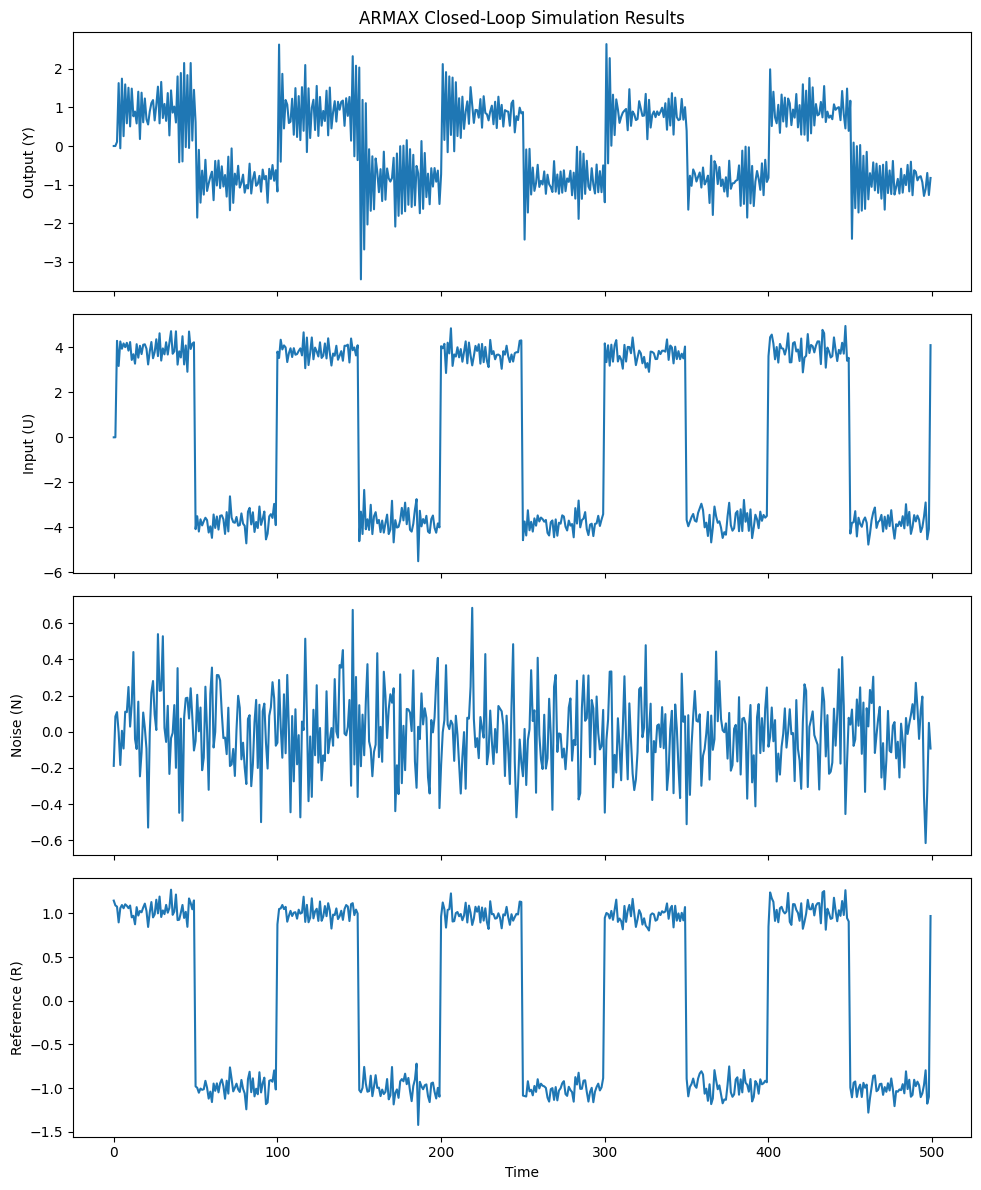

(2, 500) (1, 500) (1, 500)
True
False


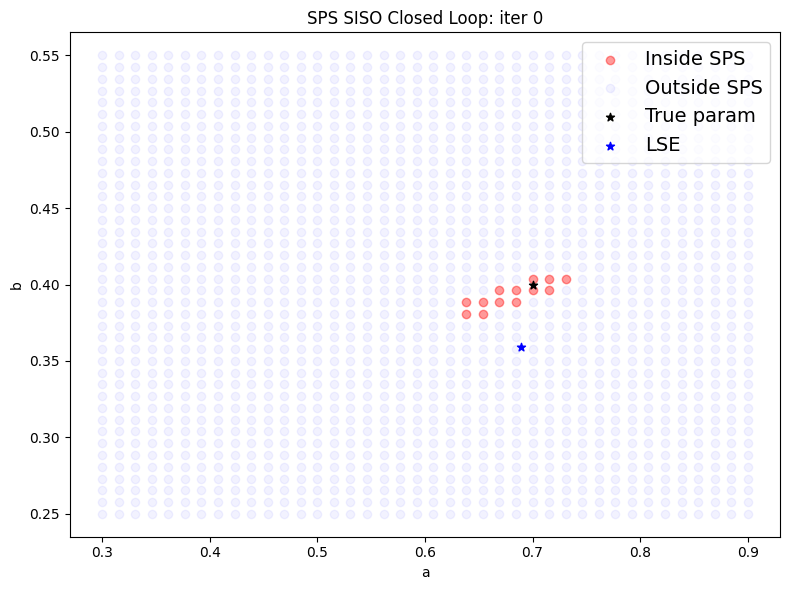

In [21]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize
from optimal_controller.optimal_controls import get_optimal_controller


n_iter = 1
for i in range(n_iter):
    Q = 0.4 * np.eye(1)
    R = 1.2*np.eye(1)
    K = get_optimal_controller(np.array(As), np.array(Bs), Q, R)
    # U = FR - LU
    K[0]

    from indirect_identification.armax import ARMAX
    from scipy.signal import lfilter, square
    import numpy as np
    # Example usage
    A = [1.0, 0.7]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
    B = [0.4]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
    C = [1.0]               # C(z^-1) = 1
    F = K[0]
    L = [4]     # L(z^-1) = 1

    armax_model = ARMAX(A, B, C, F, L)

    n_samples = 500
    # square wave reference signal
    R = square(np.linspace(0, 10*np.pi, n_samples)) + np.random.normal(0, 0.1, size=n_samples)

    Y, U, N, R = armax_model.simulate(n_samples, R=R, noise_std=0.2)
    armax_model.plot_results(Y, U, N, R)
    
    Y = Y.reshape(1,-1)
    U = U.reshape(1,-1)
    R = R.reshape(1,-1)
    print(Y.shape, U.shape, R.shape)

    def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
        """
        Returns the function to construct state space matrices from parameters.
        """

        def _construct_ss_from_params(params: np.array):
            """
            Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
            """
            # A: n_state x n_state matrix
            A =  params[:n_states]
            A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
            # B: n_state x n_input matrix
            B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
            B_obs = np.flipud(B.T)
            # C: n_output x n_state matrix
            C_obs = C
            # D: n_output x n_input matrix: zero matrix for now
            D_obs = np.zeros((n_outputs,n_inputs))

            A = np.hstack([1, A])
            B = np.hstack([np.zeros((n_inputs,1)), B])

            return A_obs, B_obs, C_obs, D_obs, A, B
        return _construct_ss_from_params

    # Example usage
    center = [0.7, 0.4]
    C_obs = np.array([[0,1],[1,0]])
    epsilon = 1e-10
    # sps 
    m = 100
    q = 5
    N = 200

    n_output=1
    n_states=1
    n_inputs=1

    model2  = SPS_indirect_model(m=m, q=q, N=N, 
                                n_states=2, n_inputs=1, n_outputs=1, 
                                n_noise=-1)
    
    def is_inside_region2(point, F=F, L=L):
        try :
            A = np.array(point[:1])
            A = np.hstack([1, A])
            B = np.array(point[1:])
            B = np.hstack([0, B])
            G = d_tfs((B, A))
            if not _is_stable(A, epsilon=epsilon):
                return False
            C = np.array([1.0])
            H = d_tfs((C, A))
            F = d_tfs((F, [1.0]))
            L =  d_tfs((L, [1.0]))
            in_sps = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                                Y_t = Y, U_t=U.reshape(1,-1), R_t=R.reshape(1,-1), sps_type=SPSType.CLOSED_LOOP, F=F, L=L)
        except Exception as e:
            in_sps = False
        return in_sps


    print(is_inside_region2(np.array(center)))
    print(is_inside_region2(lse))

    import matplotlib.pyplot as plt
    # Grid resolution
    a_vals = np.linspace(0.3, 0.9, 40)
    b_vals = np.linspace(0.25, 0.55, 40)

    blue_pts = []
    red_pts = []
    As = []
    Bs = []

    for a in a_vals:
        for b in b_vals:
            point = np.array([a, b])
            if is_inside_region2(point):
                blue_pts.append([a, b])
                As.append(a)
                Bs.append(b)
            else:
                red_pts.append([a, b])

    blue_pts = np.array(blue_pts)
    red_pts = np.array(red_pts)

    # Plotting
    plt.figure(figsize=(8, 6))  # Larger figure size for better scaling in LaTeX
    if len(blue_pts):
        plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='red', label='Inside SPS', alpha=0.4)
    if len(red_pts):
        plt.scatter(red_pts[:, 0], red_pts[:, 1], color='blue', label='Outside SPS', alpha=0.05)
    plt.scatter(center[0], center[1], color='black', marker='*', label='True param')
    plt.scatter(lse[0], lse[1], color='blue', marker='*', label='LSE')
    plt.xlabel("a")
    plt.ylabel("b")
    plt.title(f"SPS SISO Closed Loop: iter {i}")
    plt.legend(fontsize=14)
    # plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    # plt.grid(True)
    plt.tight_layout()
    # plt.savefig("sps_siso.svg", bbox_inches='tight')
    plt.show()

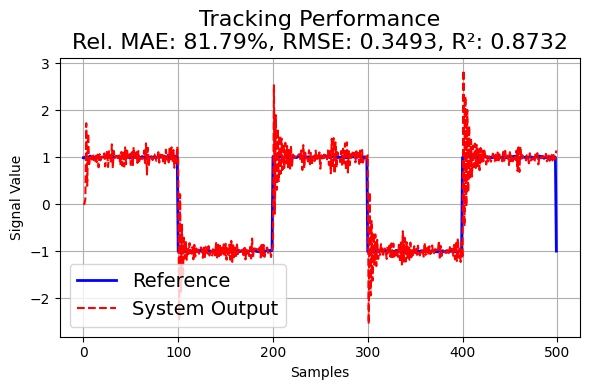

{'relative mae': 0.8179419923923743,
 'rmse': 0.34930273762294867,
 'r2': 0.8731824872913836}

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_tracking(y, r, time=None, label_r='Reference', label_y='System Output', title='Tracking Performance'):
    """
    Plots the reference signal r and the tracked output y, and computes tracking metrics.

    Parameters:
    - y: np.ndarray, tracked signal (output)
    - r: np.ndarray, reference signal (desired trajectory)
    - time: Optional time vector
    - label_r: Label for reference signal
    - label_y: Label for tracked signal
    - title: Title for the plot

    Returns:
    - metrics: dict containing relative_mae, rmse, r2
    """
    if time is None:
        time = np.arange(len(y))

    # --- Compute metrics ---
    abs_error = np.abs(y - r)
    total_error = np.sum(abs_error)
    total_reference = np.sum(np.abs(r)) + 1e-8  # Avoid division by zero

    relative_mae = 1 - total_error / total_reference
    rmse = np.sqrt(np.mean((y - r) ** 2))
    r2 = r2_score(r, y)

    # --- Plot ---
    plt.figure(figsize=(6,4))
    plt.plot(time, r, label=label_r, color='blue', linewidth=2)
    plt.plot(time, y, label=label_y, color='red', linestyle='--')
    plt.title(f"{title}\nRel. MAE: {relative_mae * 100:.2f}%, RMSE: {rmse:.4f}, R²: {r2:.4f}", fontsize=16)
    plt.xlabel("Samples")
    plt.ylabel("Signal Value")
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("sps_closed_loop_tracking.svg", bbox_inches='tight')
    plt.show()

    return {
        'relative mae': relative_mae,
        'rmse': rmse,
        'r2': r2
    }


plot_tracking(Y[0],R[0])

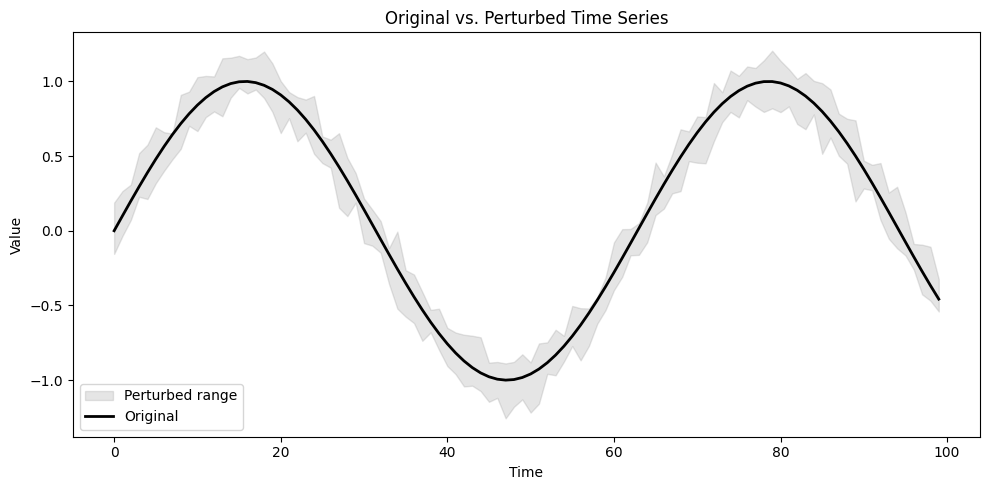

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_original_vs_perturbed(data, time=None, shade_alpha=0.2, original_color='black', shade_color='gray', title="Original vs. Perturbed Time Series"):
    """
    Plots the 0th time series as the original and shades the area spanned by the perturbed series.
    
    Parameters:
    - data: np.ndarray of shape (m, t), where m is the number of time series
    - time: Optional 1D array of length t for the x-axis. If None, uses np.arange(t)
    - shade_alpha: Alpha transparency for the shaded area
    - original_color: Color of the original time series line
    - shade_color: Color of the shaded region
    - title: Plot title
    """
    m, t = data.shape
    if time is None:
        time = np.arange(t)
    
    plt.figure(figsize=(10, 5))
    
    # Shade the region between min and max of perturbed series
    plt.fill_between(time, np.min(data[1:], axis=0), np.max(data[1:], axis=0),
                     color=shade_color, alpha=shade_alpha, label='Perturbed range')
    
    # Plot the original series
    plt.plot(time, data[0], color=original_color, linewidth=2, label='Original')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()
# Generate data as before
